In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import entropy

In [2]:
# Load the CSV file
result_csv_path = '/team/team_blu3/lung/project/luna25/weights/nodulex-v2.0.0/result_2_0_0_auroc0.8920.csv'
# result_csv_path = '/team/team_blu3/lung/project/luna25/weights/nodulex-v2.0.1/result_2_0_1_auroc0.8980.csv'
df = pd.read_csv(result_csv_path)
df.head()

,annot_ids,annotation,prob_ensemble,prob_model_0,prob_model_1,prob_model_2,prob_model_3,prob_model_4,prob_model_5
0,120067_1_19990102,0.0,0.579109,0.465428,0.496021,0.646368,0.695619,0.543596,0.627620
1,213346_2_20000102,0.0,0.195657,0.205968,0.159208,0.228614,0.162122,0.154816,0.263212
2,213346_2_20010102,0.0,0.196531,0.213284,0.161023,0.211502,0.175721,0.157876,0.259782
3,203473_1_19990102,0.0,0.576433,0.486366,0.690814,0.459944,0.619455,0.597295,0.604723
4,203473_1_20000102,0.0,0.601567,0.592260,0.663632,0.542215,0.601394,0.588481,0.621423


In [3]:
# Basic statistics
print("\n📝 Basic Statistics")
print(df.describe())


📝 Basic Statistics
       annotation  prob_ensemble  prob_model_0  prob_model_1  prob_model_2  \
count  887.000000     887.000000    887.000000    887.000000    887.000000   
mean     0.090192       0.319682      0.329875      0.298198      0.328791   
std      0.286618       0.136876      0.139036      0.160180      0.151683   
min      0.000000       0.165017      0.141859      0.107690      0.146241   
25%      0.000000       0.213760      0.223717      0.185105      0.206152   
50%      0.000000       0.268494      0.281021      0.228255      0.275253   
75%      0.000000       0.395964      0.417079      0.368841      0.414246   
max      1.000000       0.714687      0.748704      0.757582      0.750297   

       prob_model_3  prob_model_4  prob_model_5  
count    887.000000    887.000000    887.000000  
mean       0.320118      0.308920      0.332189  
std        0.154272      0.153276      0.132900  
min        0.124099      0.091151      0.138248  
25%        0.201324      0.

In [4]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
ensemble_col = 'prob_ensemble'
model_cols = [col for col in df.columns if col.startswith('prob_model_')]


📊 AUROC Scores (with 95% CI)
prob_model_0 AUROC: 0.8679 (95% CI: 0.8167 - 0.9191)
prob_model_1 AUROC: 0.8450 (95% CI: 0.7906 - 0.8995)
prob_model_2 AUROC: 0.8630 (95% CI: 0.8110 - 0.9150)
prob_model_3 AUROC: 0.8867 (95% CI: 0.8385 - 0.9348)
prob_model_4 AUROC: 0.8669 (95% CI: 0.8155 - 0.9182)
prob_model_5 AUROC: 0.8815 (95% CI: 0.8324 - 0.9305)
prob_ensemble AUROC: 0.8920 (95% CI: 0.8448 - 0.9392)


/tmp/ipykernel_74457/2983406646.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
/tmp/ipykernel_74457/2983406646.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")


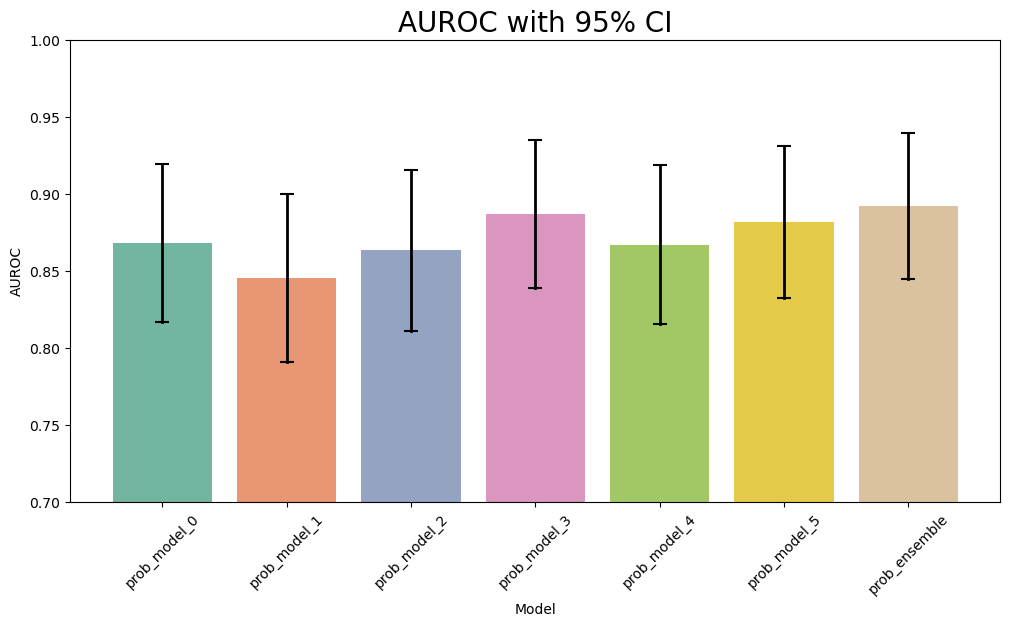

In [5]:
# Calculate AUROC scores with 95% CI
print("\n📊 AUROC Scores (with 95% CI)")
y_true = df['annotation']
auroc_scores = {}
auroc_cis = {}
for col in model_cols + [ensemble_col]:
    # Calculate AUROC
    auroc = roc_auc_score(y_true, df[col])
    auroc_scores[col] = auroc
    
    # Calculate 95% CI using DeLong method approximation
    n1 = sum(y_true == 1)
    n2 = sum(y_true == 0)
    q1 = auroc / (2 - auroc)
    q2 = 2 * (auroc ** 2) / (1 + auroc)
    se = np.sqrt((auroc * (1 - auroc) + (n1 - 1) * (q1 - auroc**2) + (n2 - 1) * (q2 - auroc**2)) / (n1 * n2))
    ci_lower = auroc - 1.96 * se
    ci_upper = auroc + 1.96 * se
    auroc_cis[col] = (ci_lower, ci_upper)
    
    print(f'{col} AUROC: {auroc:.4f} (95% CI: {ci_lower:.4f} - {ci_upper:.4f})')

# Plot AUROC with 95% CI
plt.figure(figsize=(12, 6))
auroc_df = pd.DataFrame(auroc_scores.items(), columns=["Model", "AUROC"])
auroc_df["CI Lower"], auroc_df["CI Upper"] = zip(*auroc_cis.values())
sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
for i, (ci_lower, ci_upper) in enumerate(auroc_cis.values()):
    plt.plot([i, i], [ci_lower, ci_upper], color="black", linewidth=2)
    plt.scatter([i], [ci_lower], color="black", marker="_", s=100)
    plt.scatter([i], [ci_upper], color="black", marker="_", s=100)
plt.title("AUROC with 95% CI", fontsize=20)
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.show()


📊 Sensitivity and Specificity at 95% Thresholds
prob_model_0 - Sensitivity (95% Specificity): 0.0000, Specificity (95% Sensitivity): 0.5601
prob_model_1 - Sensitivity (95% Specificity): 0.0000, Specificity (95% Sensitivity): 0.5465
prob_model_2 - Sensitivity (95% Specificity): 0.0000, Specificity (95% Sensitivity): 0.4399
prob_model_3 - Sensitivity (95% Specificity): 0.0000, Specificity (95% Sensitivity): 0.6506
prob_model_4 - Sensitivity (95% Specificity): 0.0000, Specificity (95% Sensitivity): 0.6344
prob_model_5 - Sensitivity (95% Specificity): 0.0000, Specificity (95% Sensitivity): 0.6084
prob_ensemble - Sensitivity (95% Specificity): 0.0000, Specificity (95% Sensitivity): 0.7113


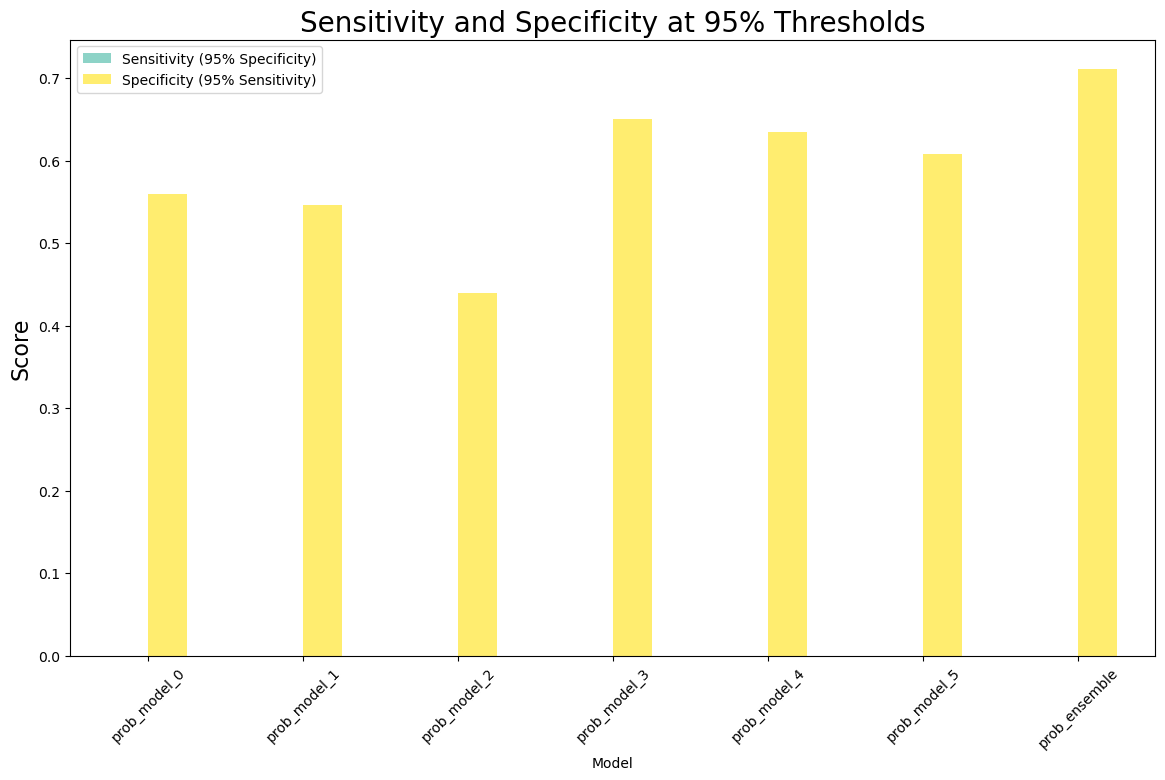

In [6]:
y_true = df['annotation']

# Sensitivity at 95% Specificity & Specificity at 95% Sensitivity
print("\n📊 Sensitivity and Specificity at 95% Thresholds")
threshold_metrics = {}
for col in model_cols + [ensemble_col]:
    fpr, tpr, thresholds = roc_curve(y_true, df[col])
    specificity_95 = 1 - fpr[np.argmax(tpr >= 0.95)]
    sensitivity_95 = tpr[np.argmax(fpr <= 0.05)]
    threshold_metrics[col] = (sensitivity_95, specificity_95)
    print(f"{col} - Sensitivity (95% Specificity): {sensitivity_95:.4f}, Specificity (95% Sensitivity): {specificity_95:.4f}")

# Plot Sensitivity and Specificity
threshold_df = pd.DataFrame(threshold_metrics.items(), columns=["Model", "Metrics"])
threshold_df["Sensitivity (95% Specificity)"], threshold_df["Specificity (95% Sensitivity)"] = zip(*threshold_df["Metrics"])
threshold_df.drop(columns=["Metrics"], inplace=True)
threshold_df.set_index("Model", inplace=True)
threshold_df.plot(kind="bar", figsize=(14, 8), colormap="Set3")
plt.title("Sensitivity and Specificity at 95% Thresholds", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Score", fontsize=16)
# plt.ylim(0.2, 1.0)
plt.show()


📊 AUROC Scores
prob_model_0 AUROC: 0.8679
prob_model_1 AUROC: 0.8450
prob_model_2 AUROC: 0.8630
prob_model_3 AUROC: 0.8867
prob_model_4 AUROC: 0.8669
prob_model_5 AUROC: 0.8815
prob_ensemble AUROC: 0.8920


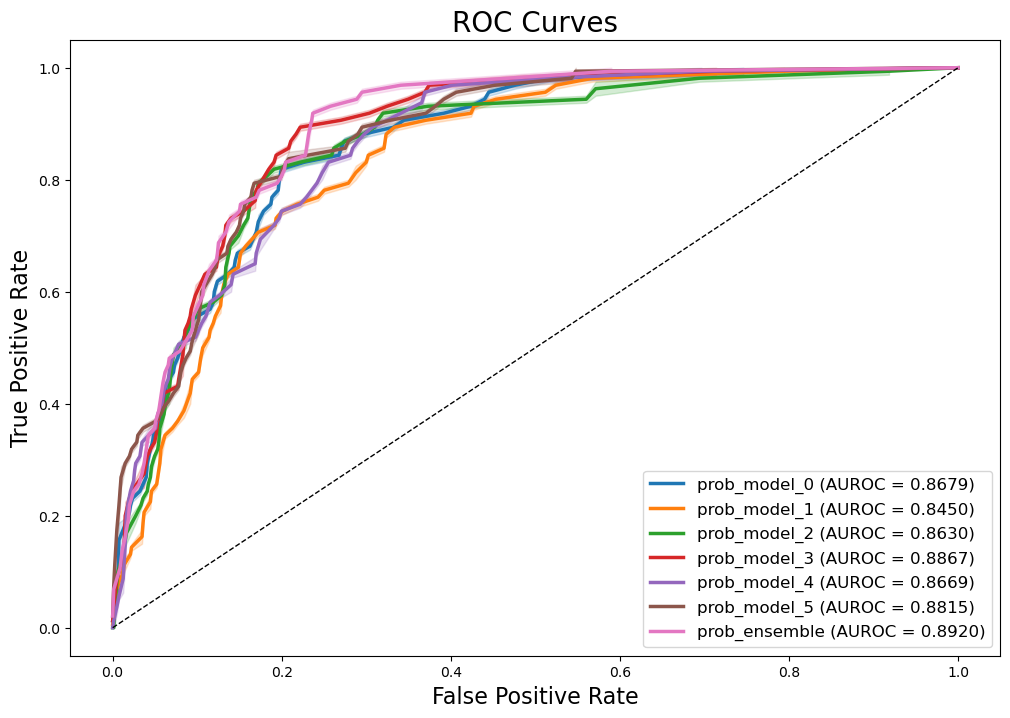

In [7]:
# Calculate AUROC scores
print("\n📊 AUROC Scores")
y_true = df['annotation']
auroc_scores = {}
for col in model_cols + [ensemble_col]:
    auroc_scores[col] = roc_auc_score(y_true, df[col])
    print(f'{col} AUROC: {auroc_scores[col]:.4f}')

# Plot ROC curves (Seaborn)
plt.figure(figsize=(12, 8))
for col in model_cols + [ensemble_col]:
    fpr, tpr, _ = roc_curve(y_true, df[col])
    sns.lineplot(x=fpr, y=tpr, label=f'{col} (AUROC = {auroc_scores[col]:.4f})', linewidth=2.5)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title('ROC Curves', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.show()


🔗 Correlation Matrix


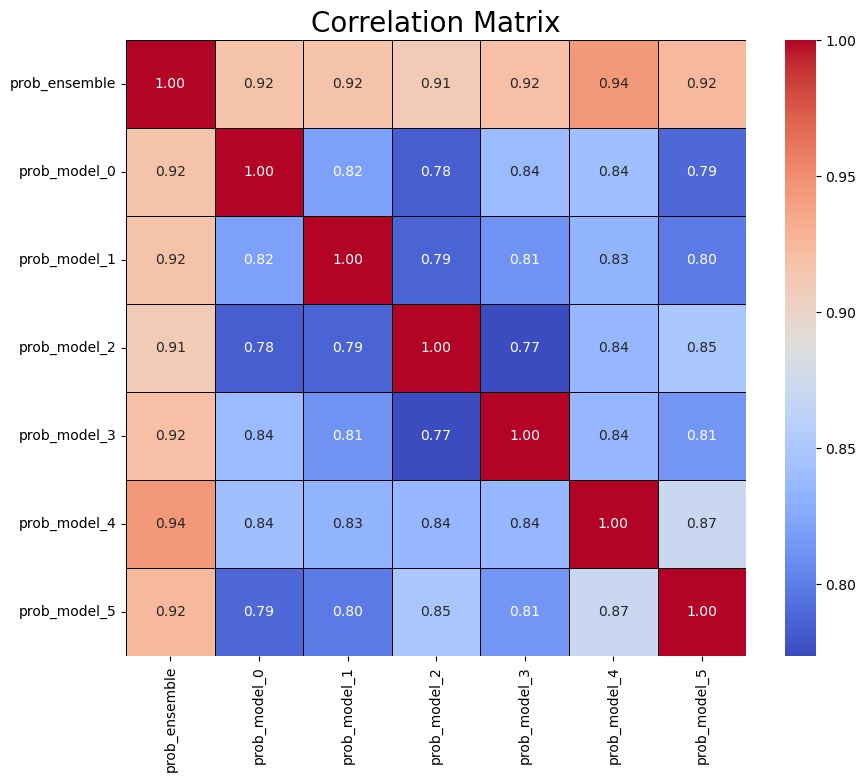

In [8]:
# Correlation matrix (Seaborn)
print("\n🔗 Correlation Matrix")
corr_matrix = df[[ensemble_col] + model_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix', fontsize=20)
plt.show()

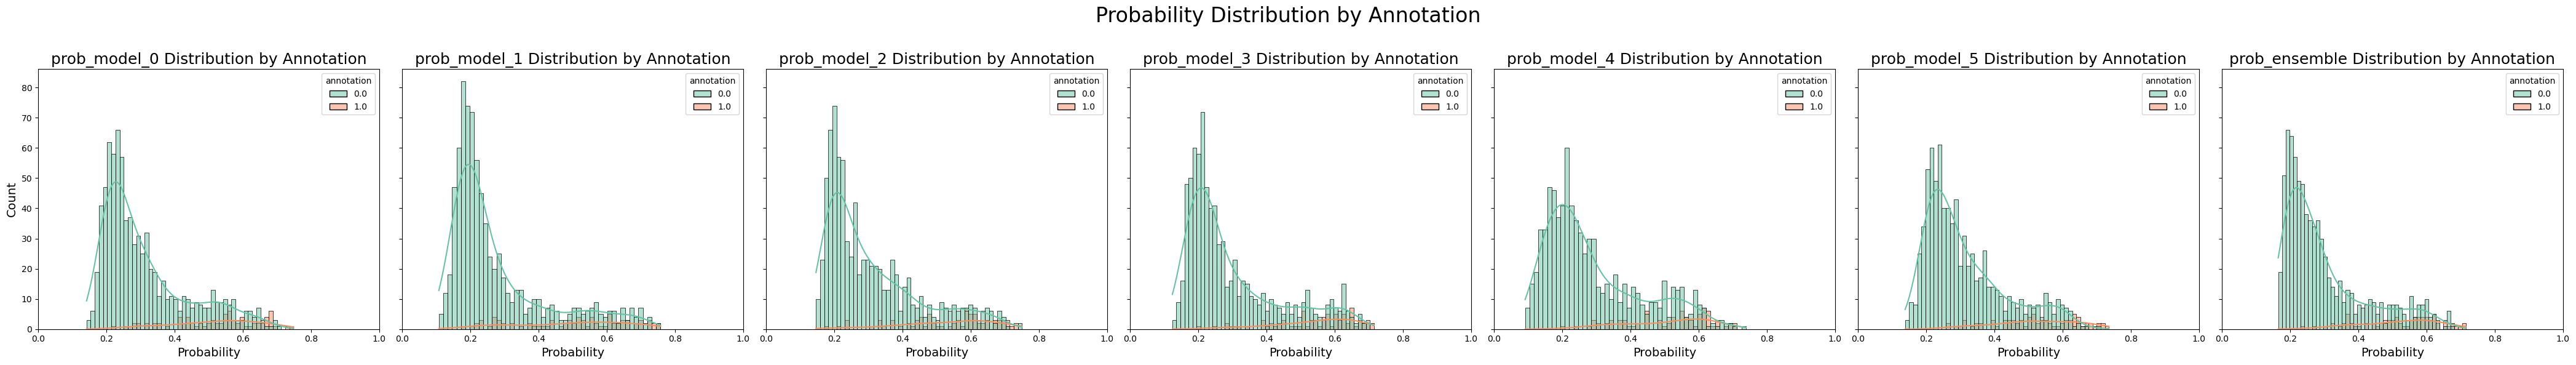

In [9]:
# Probability distribution per annotation (Seaborn, col-wise layout)
_model_cols = model_cols + [ensemble_col]
num_models = len(_model_cols)
fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 6), sharey=True)
fig.suptitle("Probability Distribution by Annotation", fontsize=24)

for i, model_col in enumerate(_model_cols):
    sns.histplot(data=df, x=model_col, hue="annotation", bins=50, kde=True, ax=axes[i], alpha=0.5, palette="Set2")
    axes[i].set_title(f"{model_col} Distribution by Annotation", fontsize=18)
    axes[i].set_xlabel("Probability", fontsize=14)
    axes[i].set_ylabel("Count", fontsize=14)
    axes[i].set_xlim(0.0, 1.0)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

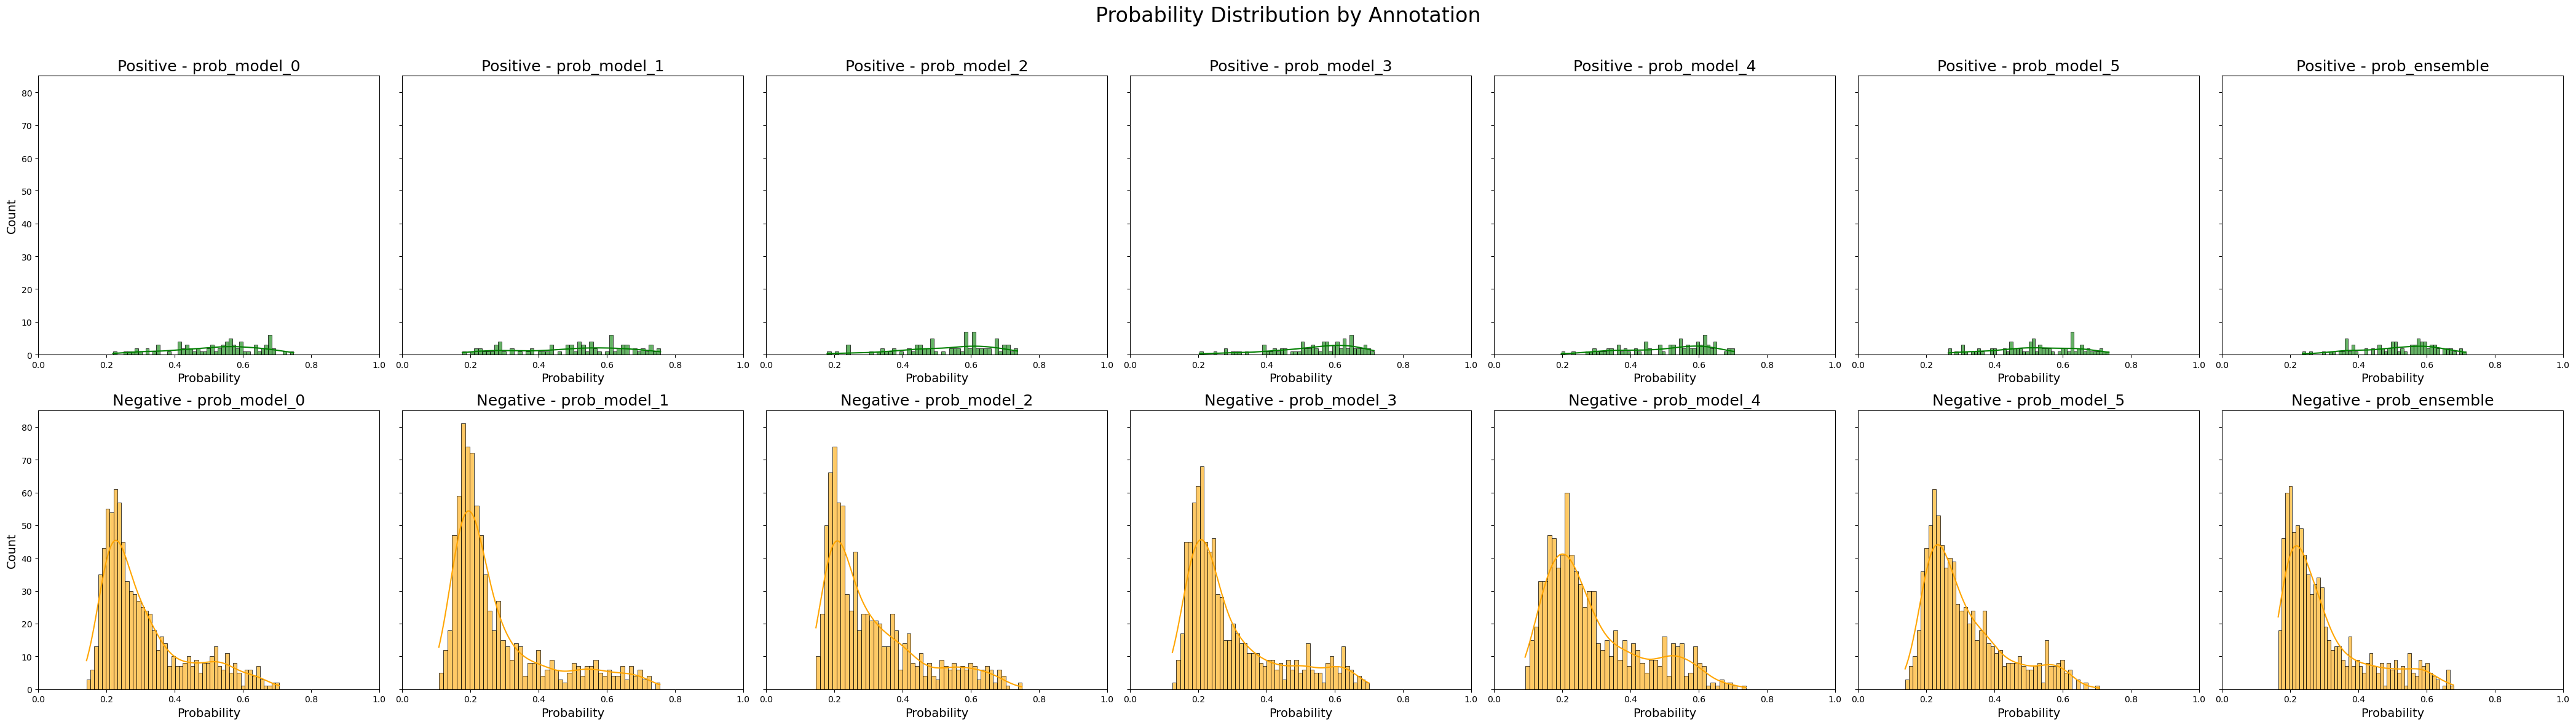

In [10]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
_model_cols = model_cols + [ensemble_col]

# Probability distribution by annotation (Seaborn, row-wise layout)
num_models = len(_model_cols)
fig, axes = plt.subplots(2, num_models, figsize=(6 * num_models, 12), sharey=True)
fig.suptitle("Probability Distribution by Annotation", fontsize=24)

for i, model_col in enumerate(_model_cols):
    # Positive annotation
    sns.histplot(data=df[df['annotation'] == 1], x=model_col, bins=50, kde=True, ax=axes[0, i], alpha=0.6, color="green")
    axes[0, i].set_title(f"Positive - {model_col}", fontsize=18)
    axes[0, i].set_xlabel("Probability", fontsize=14)
    axes[0, i].set_ylabel("Count", fontsize=14)
    axes[0, i].set_xlim(0.0, 1.0)

    # Negative annotation
    sns.histplot(data=df[df['annotation'] == 0], x=model_col, bins=50, kde=True, ax=axes[1, i], alpha=0.6, color="orange")
    axes[1, i].set_title(f"Negative - {model_col}", fontsize=18)
    axes[1, i].set_xlabel("Probability", fontsize=14)
    axes[1, i].set_ylabel("Count", fontsize=14)
    axes[1, i].set_xlim(0.0, 1.0)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


🧮 Entropy Analysis

📝 Entropy Summary
       prob_model_0  prob_model_1  prob_model_2  prob_model_3  prob_model_4  \
count    887.000000    887.000000    887.000000    887.000000    887.000000   
mean       0.853073      0.794573      0.839889      0.827488      0.813484   
std        0.104433      0.127656      0.114752      0.120714      0.145946   
min        0.589087      0.492908      0.600352      0.541028      0.440302   
25%        0.766896      0.691119      0.734061      0.724569      0.701763   
50%        0.855149      0.774958      0.846092      0.815367      0.821115   
75%        0.951988      0.911324      0.952859      0.949241      0.959581   
max        1.000000      1.000000      0.999983      0.999986      1.000000   

       prob_model_5  prob_ensemble  
count    887.000000     887.000000  
mean       0.860746       0.843650  
std        0.102712       0.107453  
min        0.579633       0.646178  
25%        0.775340       0.748608  
50%        0.862981       0

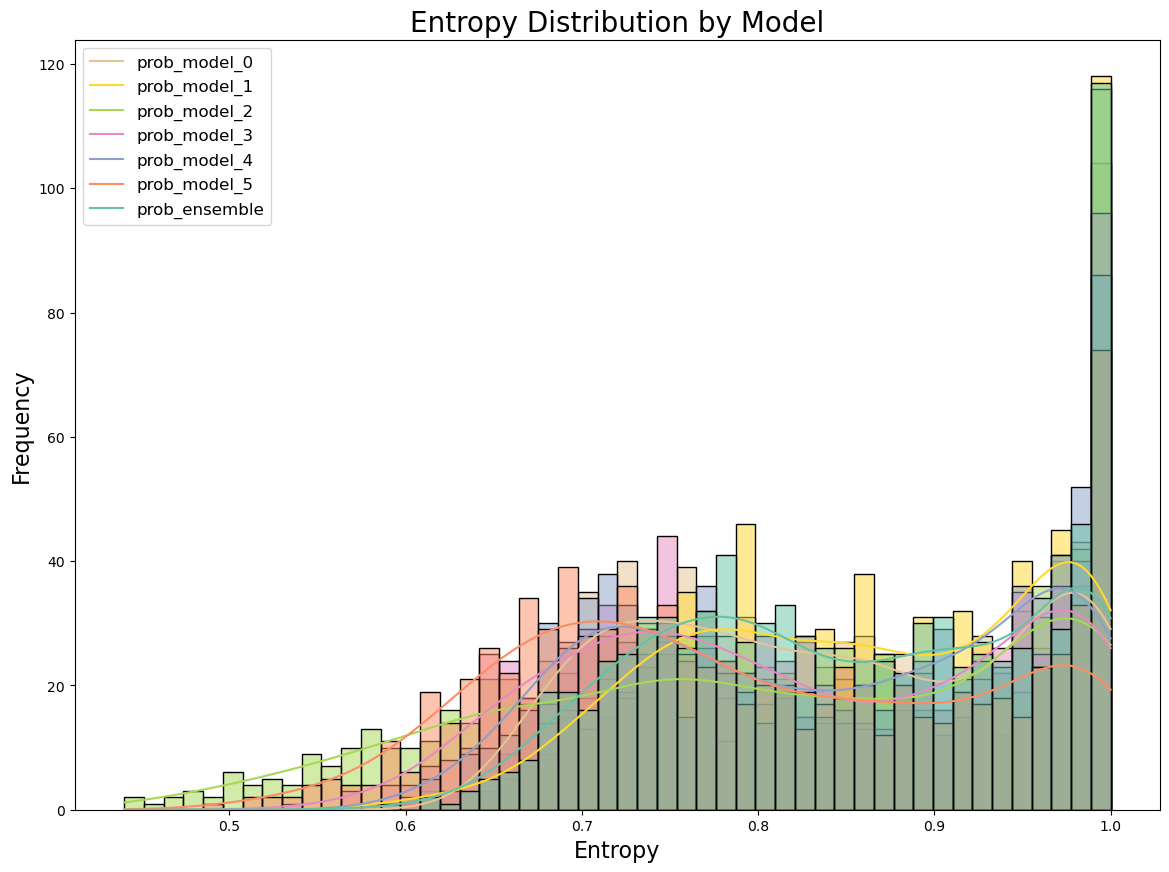

In [11]:
# Entropy calculation
print("\n🧮 Entropy Analysis")
entropy_df = pd.DataFrame()
for col in model_cols + [ensemble_col]:
    probs = df[col].values
    entropies = -(probs * np.log2(probs + 1e-10) + (1 - probs) * np.log2(1 - probs + 1e-10))
    entropy_df[col] = entropies

# Entropy summary
print("\n📝 Entropy Summary")
print(entropy_df.describe())

# Plot entropy distributions (Seaborn)
plt.figure(figsize=(14, 10))
sns.histplot(entropy_df, kde=True, bins=50, alpha=0.5, palette='Set2')
plt.title('Entropy Distribution by Model', fontsize=20)
plt.xlabel('Entropy', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(entropy_df.columns, fontsize=12)
plt.show()

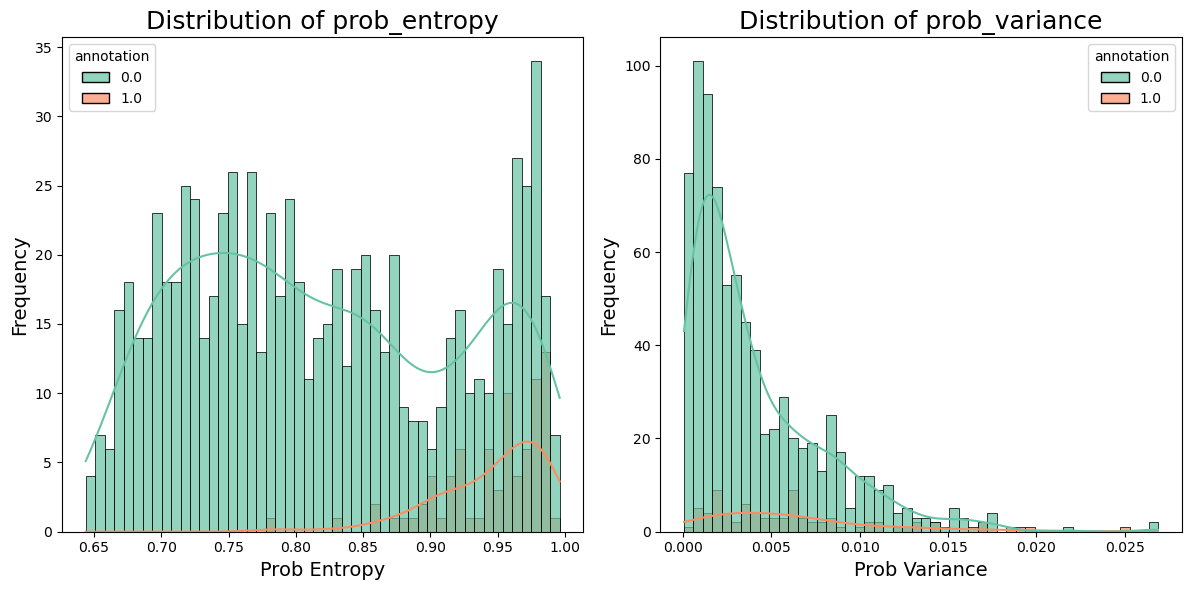


📝 Metric Summary Statistics
       prob_entropy  prob_variance
count    887.000000     887.000000
mean       0.831543       0.004288
std        0.102446       0.004050
min        0.643907       0.000052
25%        0.743800       0.001320
50%        0.826957       0.002934
75%        0.930426       0.006178
max        0.996079       0.026885


In [12]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
ensemble_col = 'prob_ensemble'
model_cols = [col for col in df.columns if col.startswith('prob_model_')]

# Correct entropy calculation for binary classification
binary_entropies = []
for _, row in df[model_cols].iterrows():
    entropies = - (row.values * np.log2(row.values + 1e-10) + (1 - row.values) * np.log2(1 - row.values + 1e-10))
    binary_entropies.append(np.mean(entropies))

df["prob_entropy"] = binary_entropies
df["prob_variance"] = df[model_cols].var(axis=1)

# Plot distributions
metrics = ["prob_entropy", "prob_variance"]
plt.figure(figsize=(18, 6))
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data=df, x=metric, hue="annotation", bins=50, kde=True, palette="Set2", alpha=0.7)
    plt.title(f"Distribution of {metric}", fontsize=18)
    plt.xlabel(metric.replace('_', ' ').title(), fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n📝 Metric Summary Statistics")
print(df[metrics].describe())

In [13]:
# Sort by entropy, variance, and CV for each annotation
sorted_positive = df[df["annotation"] == 1].sort_values(by="prob_variance", ascending=False)
sorted_negative = df[df["annotation"] == 0].sort_values(by="prob_variance", ascending=False)

# Select top N samples
N = 20
top_positive = sorted_positive.head(N)
top_negative = sorted_negative.head(N)

# Display the selected samples
print("\n🔎 Top Positive Samples (High variance)")
print(top_positive[["annotation", "prob_entropy", "prob_variance"] + model_cols].reset_index(drop=True))

print("\n🔎 Top Negative Samples (High variance)")
print(top_negative[["annotation", "prob_entropy", "prob_variance"] + model_cols].reset_index(drop=True))


🔎 Top Positive Samples (High variance)
    annotation  prob_entropy  prob_variance  prob_model_0  prob_model_1  \
0          1.0      0.912217       0.024841      0.685246      0.283532   
1          1.0      0.902475       0.019391      0.439504      0.289716   
2          1.0      0.901423       0.019160      0.447867      0.228398   
3          1.0      0.947912       0.016960      0.566201      0.234895   
4          1.0      0.898777       0.016942      0.289863      0.176533   
5          1.0      0.964619       0.014471      0.383704      0.654133   
6          1.0      0.955548       0.014377      0.658780      0.435831   
7          1.0      0.912529       0.013121      0.416679      0.265965   
8          1.0      0.958143       0.013096      0.509956      0.344354   
9          1.0      0.914554       0.012734      0.436199      0.274625   
10         1.0      0.929058       0.012106      0.271517      0.253050   
11         1.0      0.940271       0.011148      0.471770   

In [14]:
import pymongo

from data_lake.constants import DB_ADDRESS, TARGET_COLLECTION, TARGET_DB

_CLIENT = pymongo.MongoClient(DB_ADDRESS)
_TARGET_FIELD = {}
_PROJECTION = {field: 1 for field in _TARGET_FIELD}

for _, row in top_positive.iterrows():
    query = {"annotation_id": row.annot_ids}
    nodule_candidates = [x for x in _CLIENT[TARGET_DB][TARGET_COLLECTION].find(query, _PROJECTION)]
    break


In [15]:
nodule_candidates

[{'_id': ObjectId('67f76d7650a0262ec4785b59'),
  'patient_id': 119597,
  'series_instance_uid': '1.2.840.113654.2.55.135968128742262057179054957067531073282',
  'annotation_id': '119597_1_19990102',
  'studydate': 19990102,
  'h5_path_nfs': '/team/team_blu3/lung/data/2_public/LUNA25_h5/1.2.840.113654.2.55.135968128742262057179054957067531073282.h5',
  'h5_path': '/nvme1/1_dataset/LUNA25_h5/1.2.840.113654.2.55.135968128742262057179054957067531073282.h5',
  'fold': 6,
  'label': 1,
  'age_at_study': 58,
  'gender': 'Female',
  'origin': [1331.5, -136.7187042236328, -158.5937042236328],
  'transform': [[2.0, 0.0, 0.0],
   [0.0, 0.5460000038146973, 0.0],
   [0.0, 0.0, 0.5460000038146973]],
  'spacing': [2.0, 0.5460000038146973, 0.5460000038146973],
  'resampled_spacing': [1.0, 0.67, 0.67],
  'w_coord_zyx': [1496.15, -14.91, -126.83],
  'd_coord_zyx': [82.32500000000005, 223.0928633197822, 58.17528205441708],
  'r_coord_zyx': [165.18112903225816, 181.61767346581095, 47.35991650613993]}]